In [18]:
# import packages
import sys

import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.25.2
tensorflow version = 2.14.0


In [7]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

# Data preparation

In [9]:
# read in data
ORAp_t = '../data/sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = '../data/sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = '../data/sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = '../data/somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

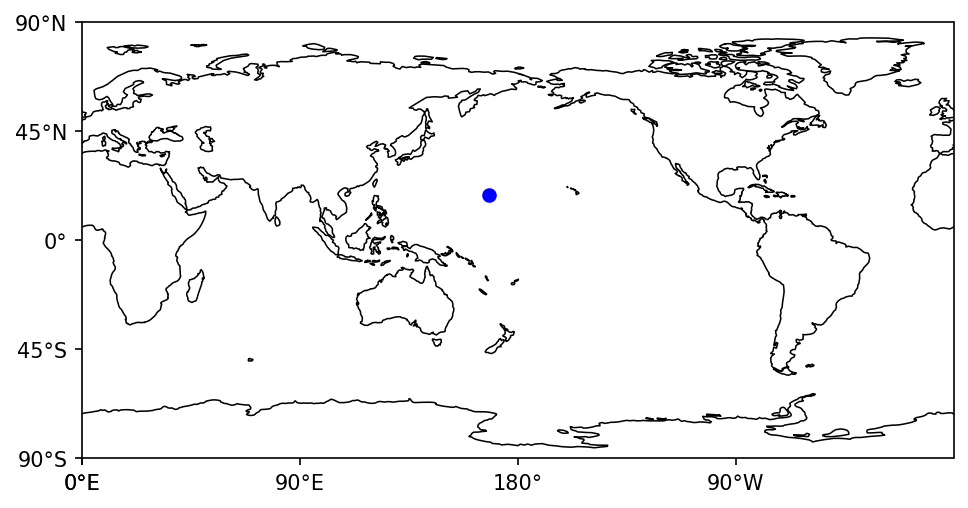

In [12]:
# pick a grid point
ilat = 90
ilon = 140

if ma.is_masked(ORA_SST[:,ilat,ilon]):
    print('Land! Try to pick a ocean grid :D')
else:
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(linewidth=.75)
    ax.set_global()

    ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.plot(lon[ilon], lat[ilat], 'ob', transform=ccrs.PlateCarree())
    
    plt.show()

In [13]:
# calculate climatology
OSST_c = np.nanmean(np.array(ORA_SST[:,ilat,ilon]).reshape((int(len(ORA_SST[:,ilat,ilon])/12), 12)), axis=0)
OSSH_c = np.nanmean(np.array(ORA_SSH[:,ilat,ilon]).reshape((int(len(ORA_SSH[:,ilat,ilon])/12), 12)), axis=0)
OSSS_c = np.nanmean(np.array(ORA_SSS[:,ilat,ilon]).reshape((int(len(ORA_SSS[:,ilat,ilon])/12), 12)), axis=0)
OMLD_c = np.nanmean(np.array(ORA_MLD[:,ilat,ilon]).reshape((int(len(ORA_MLD[:,ilat,ilon])/12), 12)), axis=0)
OSST_cf = np.tile(OSST_c, int(len(ORA_SST[:,ilat,ilon])/12))
OSSH_cf = np.tile(OSSH_c, int(len(ORA_SSH[:,ilat,ilon])/12))
OSSS_cf = np.tile(OSSS_c, int(len(ORA_SSS[:,ilat,ilon])/12))
OMLD_cf = np.tile(OMLD_c, int(len(ORA_MLD[:,ilat,ilon])/12))

# remove climatology (just for predictors)
OSST_a = ORA_SST[:,ilat,ilon] - OSST_cf
OSSH_a = ORA_SSH[:,ilat,ilon] - OSSH_cf
OSSS_a = ORA_SSS[:,ilat,ilon] - OSSS_cf

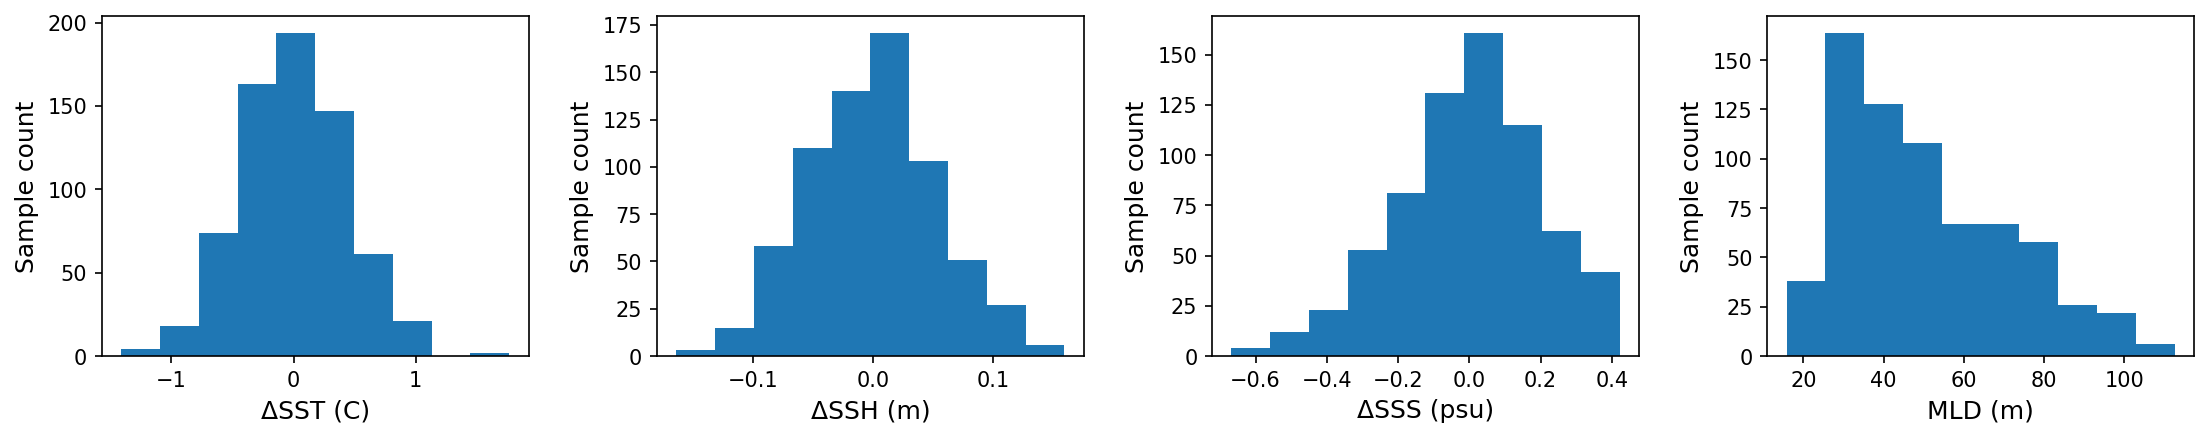

In [14]:
# check timeseries distribution
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_ylabel('Sample count')

axs[0].set_xlabel('\u0394SST (C)')
axs[1].set_xlabel('\u0394SSH (m)')
axs[2].set_xlabel('\u0394SSS (psu)')
axs[3].set_xlabel('MLD (m)')

axs[0].hist(OSST_a)
axs[1].hist(OSSH_a)
axs[2].hist(OSSS_a)
axs[3].hist(ORA_MLD[:,ilat,ilon])
        
fig.subplots_adjust(wspace=0.3)
plt.show()

In [15]:
# predictors and predictand
X = np.empty((len(OSST_a), 7))
X[:,:] = np.nan

X[:,0] = monthofYear
X[:,1] = OSST_cf
X[:,2] = OSSH_cf
X[:,3] = OSSS_cf
X[:,4] = OSST_a
X[:,5] = OSSH_a
X[:,6] = OSSS_a

y = np.copy(ORA_MLD[:,ilat,ilon])

label_names = ['MLD']
feature_list = ['month of year', 'SST - climatology', 'SSH - climatology', 'SSS - climatology', 'SST - anomaly', 'SSH - anomaly', 'SSS - anomaly']

# Train/test set

In [19]:
# spliting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # the same as in the random forest model

# how about spliting dataset by different time periods?

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (513, 7)
Testing Features Shape: (171, 7)


In [20]:
# standardize inputs and output
standardize_input = lambda dat, x, s: (dat - x) / s

# Calculate mean and standard deviation of the training data
trainmean = X_train.mean(axis=0)
trainstd = X_train.std(axis=0)

Xtrain = standardize_input(X_train, trainmean, trainstd)
Xtest = standardize_input(X_test, trainmean, trainstd)